This notebook provides examples to: 

1. Compare tuning bagging hyperparameters with OOB validation and $k$-fold cross-validation. 

2. Compare bagging tuned models with untuned models.

In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score,train_test_split, KFold, GridSearchCV, ParameterGrid, \
RandomizedSearchCV, RepeatedKFold
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.ensemble import BaggingRegressor,BaggingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, \
accuracy_score, precision_score, confusion_matrix, mean_squared_error, r2_score, mean_squared_error
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from skopt.plots import plot_convergence, plot_histogram, plot_objective
from IPython import display
import itertools as it

#Libraries for visualizing trees
from sklearn.tree import export_graphviz, export_text
from six import StringIO
from IPython.display import Image  
import pydotplus
import time as time
import warnings

In [17]:
#Using the same datasets as in linear regression in STAT303-2, 
#so that we can compare the non-linear models with linear regression
trainf = pd.read_csv('./Datasets/Car_features_train.csv')
trainp = pd.read_csv('./Datasets/Car_prices_train.csv')
testf = pd.read_csv('./Datasets/Car_features_test.csv')
testp = pd.read_csv('./Datasets/Car_prices_test.csv')
train = pd.merge(trainf,trainp)
test = pd.merge(testf,testp)
train.head()

,carID,brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,price
0,18473,bmw,6 Series,2020,Semi-Auto,11,Diesel,145,53.3282,3.0,37980
1,15064,bmw,6 Series,2019,Semi-Auto,10813,Diesel,145,53.0430,3.0,33980
2,18268,bmw,6 Series,2020,Semi-Auto,6,Diesel,145,53.4379,3.0,36850
3,18480,bmw,6 Series,2017,Semi-Auto,18895,Diesel,145,51.5140,3.0,25998
4,18492,bmw,6 Series,2015,Automatic,62953,Diesel,160,51.4903,3.0,18990


In [18]:
X = train[['mileage','mpg','year','engineSize']]
Xtest = test[['mileage','mpg','year','engineSize']]
y = train['price']
ytest = test['price']

1. Tree without tuning
2. Tree performance improves with tuning
3. Bagging tuned tree
4. Bagging untuned tree - better, how?
5. Tuning bagged model - OOB
6. Tuning bagged model - BayesSearchCV
7. warm start
8. Bagging KNN - no need to tune number of neighbors

## Tree without tuning

In [37]:
model = DecisionTreeRegressor()
cv = KFold(n_splits=5, shuffle=True, random_state=1)
-np.mean(cross_val_score(model, X, y, scoring='neg_root_mean_squared_error', cv = cv))

7056.960817154941

['max_depth'] = [10] 6341.1481858990355


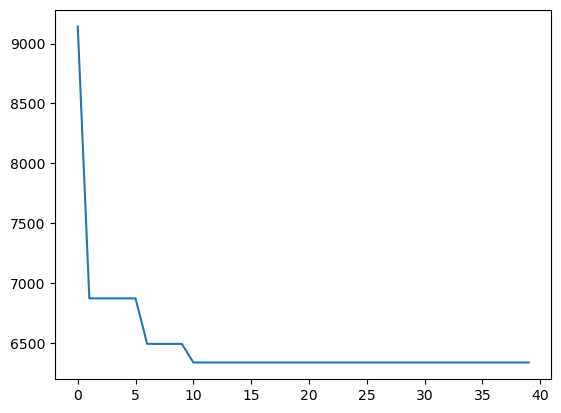

BayesSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
              estimator=DecisionTreeRegressor(), n_iter=40, n_jobs=-1,
              random_state=10, scoring='neg_root_mean_squared_error',
              search_spaces={'max_depth': Integer(low=2, high=30, prior='uniform', transform='normalize')})

In [41]:
param_grid = {'max_depth': Integer(2, 30)}
gcv = BayesSearchCV(model, search_spaces = param_grid, cv = cv, n_iter = 40, random_state = 10,
                         scoring = 'neg_root_mean_squared_error', n_jobs = -1)
paras = list(gcv.search_spaces.keys())
paras.sort()

def monitor(optim_result):
    cv_values = pd.Series(optim_result['func_vals']).cummin()
    display.clear_output(wait = True)
    min_ind = pd.Series(optim_result['func_vals']).argmin()
    print(paras, "=", optim_result['x_iters'][min_ind], pd.Series(optim_result['func_vals']).min())
    sns.lineplot(cv_values)
    plt.show()
gcv.fit(X, y, callback = monitor)    

## Performance of tree improves with tuning

In [42]:
model = DecisionTreeRegressor(max_depth=10)
cv = KFold(n_splits=5, shuffle=True, random_state=1)
-np.mean(cross_val_score(model, X, y, scoring='neg_root_mean_squared_error', cv = cv))

6442.494300778735

## Bagging tuned trees

In [53]:
model = BaggingRegressor(DecisionTreeRegressor(max_depth = 10), oob_score=True, n_estimators = 100).fit(X, y)
mean_squared_error(model.oob_prediction_, y, squared = False)

5354.357809020438

## Bagging untuned trees

In [122]:
model = BaggingRegressor(DecisionTreeRegressor(), oob_score=True, n_estimators = 100).fit(X, y)
mean_squared_error(model.oob_prediction_, y, squared = False)

5248.720845665685

**Why is bagging tuned trees worse than bagging untuned trees?**

In the tuned tree here, the reduction in variance by controlling maximum depth resulted in an increas in bias of indivudual trees. Bagging trees only reduces the variance, but not the bias of the indivudal trees. Thus, bagging high bias models will result in a high-bias model, while bagging high variance models may result in a low variance model if the models are not highly correlated.

Bagging tuned models may provide a better performance as compared to bagging untuned models if the reduction in variance of the individual models is high enough to overshadow the increase in bias, and increase in pairwise correlation of the individual models.

## Tuning bagged model - OOB

In [129]:
param_grid1 = {'max_samples': [0.25, 0.5, 0.75, 1.0],
             'max_features': [2, 3, 4],
             'bootstrap_features': [True, False]}
param_grid2 = {'max_samples': [0.25, 0.5, 0.75, 1.0],
             'max_features': [1],
              'bootstrap_features': [False]}
param_list1 = list(it.product(*[values for key, values in param_grid1.items()]))
param_list2 = list(it.product(*[values for key, values in param_grid2.items()]))
param_list = param_list1 + param_list2

In [131]:
oob_score_pr = []
for pr in param_list:
    model = BaggingRegressor(DecisionTreeRegressor(), max_samples=pr[0], max_features=pr[1],
                            bootstrap_features=pr[2], n_jobs = -1, oob_score=True, n_estimators = 50).fit(X, y)
    oob_score_pr.append(mean_squared_error(model.oob_prediction_, y, squared=False))

**What is the benefit of OOB validation to tune hyperparameters in bagging?**

It is much cheaper than $k$-fold cross-validation, as only $1/k$ of the models are trained with OOB validation as compared to $k$-fold cross-validation. However, the cost of training individual models is lower in $k$-fold cross-validation as models are trained on a smaller dataset. Typically, OOB will be faster than $k$-fold cross-validation. The higher the value of $k$, the more faster OOB validation will be as compared to $k$-fold cross-validation. 

## Tuning without k-fold cross-validation

**When hyperparameters can be tuned with OOB validation, what is the benefit of using k-fold cross-validation?**

1. Hyperparameters cannot be tuned over continuous spaces with OOB validation. 

2. OOB score is not computed if samping is done without replacement *(`bootstrap = False`)*. Thus, for tuning the `bootstrap` hyperparameter, $k$-fold cross-validation will need to be used. 

In [138]:

def monitor(optim_result):
    cv_values = pd.Series(optim_result['func_vals']).cummin()
    display.clear_output(wait = True)
    min_ind = pd.Series(optim_result['func_vals']).argmin()
    print(paras, "=", optim_result['x_iters'][min_ind], pd.Series(optim_result['func_vals']).min())
    sns.lineplot(cv_values)
    plt.show()

['bootstrap', 'bootstrap_features', 'max_features', 'max_samples'] = [True, False, 4, 0.8061354588503475] 5561.064432968422


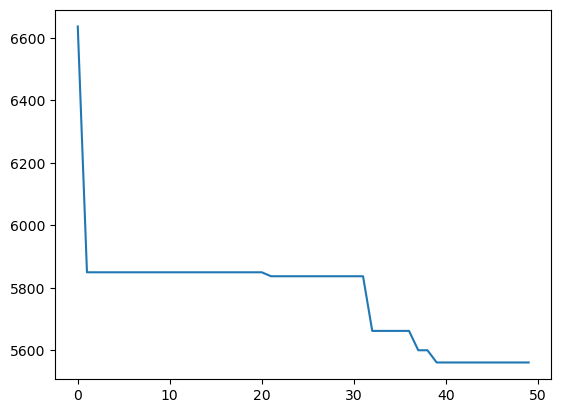

BayesSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
              estimator=BaggingRegressor(bootstrap=False,
                                         estimator=DecisionTreeRegressor()),
              n_jobs=-1, scoring='neg_root_mean_squared_error',
              search_spaces={'bootstrap': [True, False],
                             'bootstrap_features': [True, False],
                             'max_features': Integer(low=1, high=4, prior='uniform', transform='normalize'),
                             'max_samples': Real(low=0.2, high=1.0, prior='uniform', transform='normalize')})

In [139]:
param_grid = {'max_samples': Real(0.2, 1.0),
             'max_features': Integer(1, 4),
             'bootstrap_features': [True, False],
              'bootstrap': [True, False]}
gcv = BayesSearchCV(BaggingRegressor(DecisionTreeRegressor(), bootstrap=False), 
                    search_spaces = param_grid, cv = cv, n_jobs = -1,
                  scoring='neg_root_mean_squared_error')

paras = list(gcv.search_spaces.keys())
paras.sort()

gcv.fit(X, y, callback=monitor)


<Axes: xlabel='bootstrap', ylabel='Sample Count'>

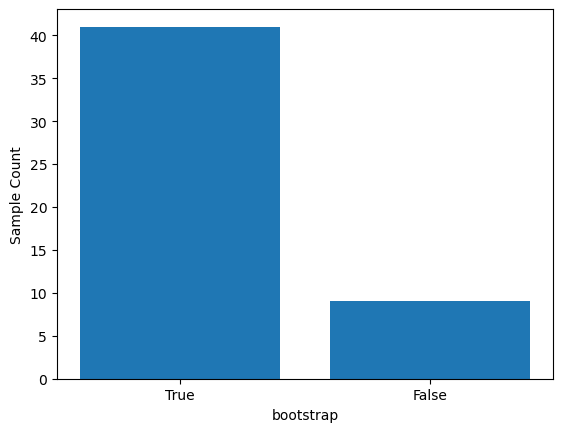

In [146]:
plot_histogram(gcv.optimizer_results_[0],0)

<Axes: >

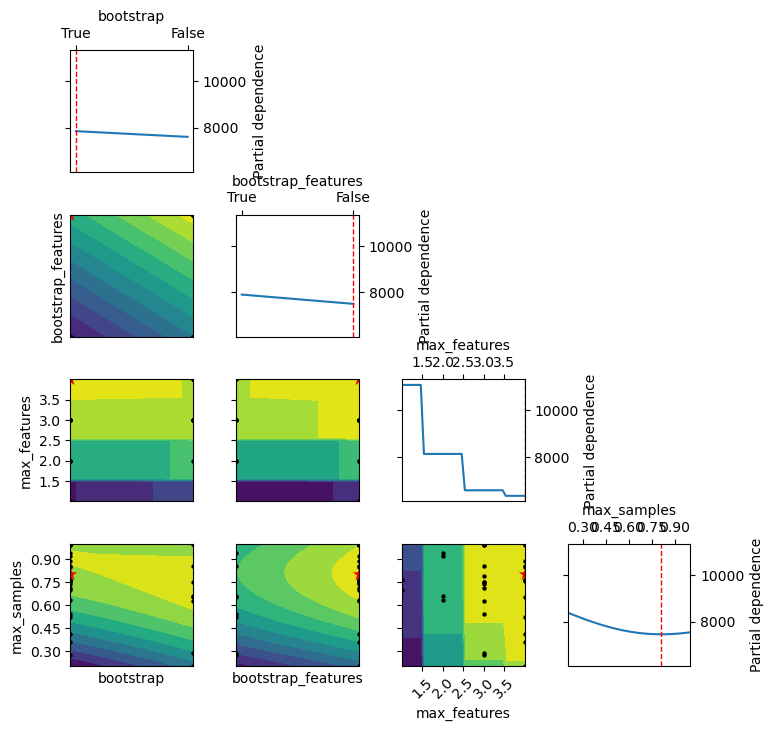

In [147]:
plot_objective(gcv.optimizer_results_[0])

## warm start

**What is the purpose of warm_start?**

The purpose of `warm_start` is to avoid developing trees from scratch, and incrementally add trees to monitor the validation error. However, note that OOB score is not computed with `warm_start`. Thus, a validation set approach will need to be adopted to tune number of trees. 

A cheaper approach to tune number of estimators is to just use trial and error, and stop increasing once the cross-validation error / OOB error / validation set error stabilizes.

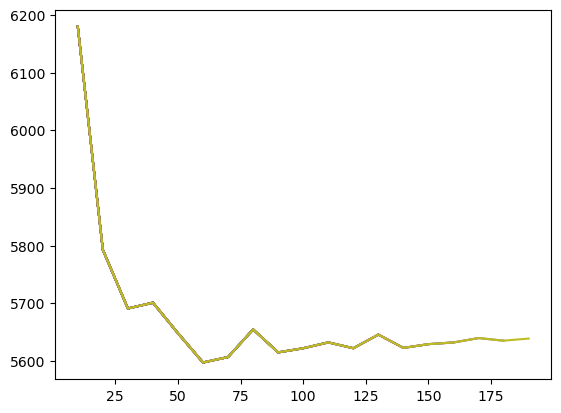

In [151]:
model = BaggingRegressor(DecisionTreeRegressor(), oob_score=False, n_estimators = 5,
                        warm_start=True).fit(X, y)
rmse = []
for i in range(10, 200, 10):
    model.n_estimators = i
    model.fit(X, y)
    rmse.append(mean_squared_error(model.predict(Xtest), ytest, squared=False))
    sns.lineplot(x = range(10, i+1, 10), y = rmse)

## Bagging KNN
**Should we bag a tuned KNN model or an untuned one?**

In [157]:
from sklearn.preprocessing import StandardScaler

In [169]:
model = KNeighborsRegressor(n_neighbors=9) # optimal neigbors
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
-np.mean(cross_val_score((model), X_scaled, y, cv = cv, 
                         scoring='neg_root_mean_squared_error', n_jobs = -1))

6972.997277781689

In [175]:
model = KNeighborsRegressor(n_neighbors=1)
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
-np.mean(cross_val_score(BaggingRegressor(model), X_scaled, y, cv = cv, 
                         scoring='neg_root_mean_squared_error', n_jobs = -1))

6254.305462266355

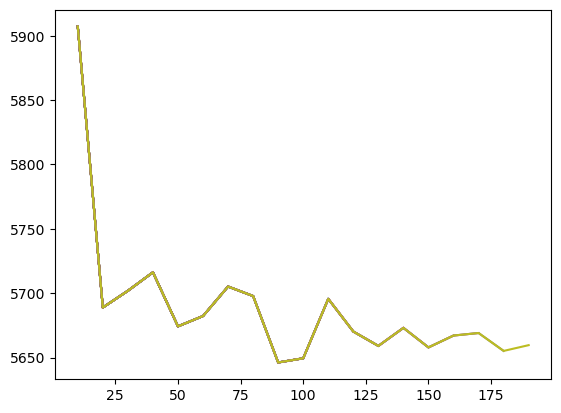

In [187]:
model = BaggingRegressor(DecisionTreeRegressor(), n_estimators=5, warm_start=True)
model.fit(X, y)
rmse = []
for i in range(10, 200,10):
    model.n_estimators = i
    model.fit(X, y)
    rmse.append(mean_squared_error(model.predict(Xtest), ytest, squared=False))
    sns.lineplot(x = range(10, i + 1, 10), y = rmse)